# **Step 1: Loading Libraries and  Exploring Dataset**


Dataset Head:
                                           Statement      Status
0  life doesn’t feel worth it that’s kind of it? ...  Depression
1  This life sucks and if it were for my religiou...  Depression
2  its been 9 months now for our marriage and she...      Stress
3  I do not feel particularly sad or anxious or a...  Depression
4  I am taking Venlafaxine. it is an SSRI. does n...  Depression

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  36876 non-null  object
 1   Status     37130 non-null  object
dtypes: object(2)
memory usage: 580.3+ KB
None

Missing Values:
Statement    254
Status         0
dtype: int64
Missing Values Per Class:
                      Statement  Status
Status                                 
Anxiety                      30       0
Bipolar                      73       0
Depression          

<ipython-input-8-524addfc34da>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())


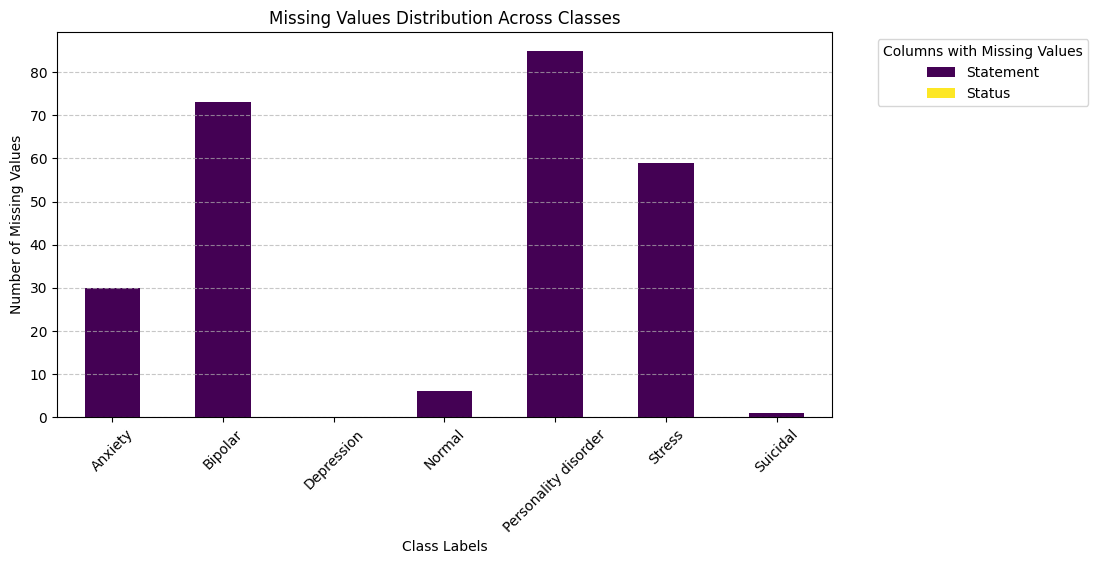

Number of Instances Per Class:
Status
Normal                  11446
Depression              10783
Suicidal                 7457
Anxiety                  2721
Bipolar                  2014
Stress                   1868
Personality disorder      841
Name: count, dtype: int64


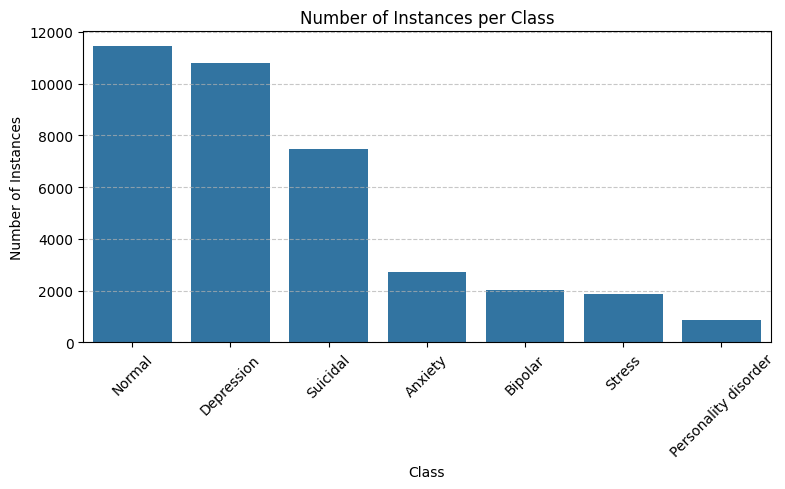

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv("Sentiment_analysis_dataset.csv")
# Inspect Data
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for missing values per class
missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())

# Display missing values per class
print("Missing Values Per Class:")
print(missing_values_per_class)

# Plot Bar Graph
missing_values_per_class.plot(kind='bar', figsize=(10, 5), stacked=True, colormap='viridis')
plt.title("Missing Values Distribution Across Classes")
plt.xlabel("Class Labels")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.legend(title="Columns with Missing Values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Count instances per class
class_counts = df['Status'].value_counts()

# Print number of instances per class
print("Number of Instances Per Class:")
print(class_counts)

# Plot number of instances per class
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Instances per Class")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Count instances per class
class_counts = df['Status'].value_counts()


**AUGMENTING SEGMENT**

In [9]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import random

# --- Preprocessing: Drop rows with missing 'Statement'
before_drop = df.shape[0]
df.dropna(subset=['Statement'], inplace=True)
df.reset_index(drop=True, inplace=True)
after_drop = df.shape[0]
print(f"Rows before drop: {before_drop}")
print(f"Rows after drop: {after_drop}")
print(f"Total rows dropped: {before_drop - after_drop}")

# --- Download necessary resources if not already done
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')  # Download the missing resource

# --- Define Augmentation Functions

def get_synonyms(word):
    """Return a list of synonyms for a given word using WordNet."""
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            possible_syn = lemma.name().replace("_", " ")
            if possible_syn.lower() != word.lower() and possible_syn not in synonyms:
                synonyms.append(possible_syn)
    return synonyms

def synonym_augmentation(text, p=0.3):
    """
    Replace words in the text with synonyms with probability p.
    This helps introduce variability into your dataset.
    """
    words = word_tokenize(text)
    augmented_words = []
    for w in words:
        # With probability p, try replacing the word with one of its synonyms.
        if random.random() < p:
            syns = get_synonyms(w)
            if syns:
                new_w = random.choice(syns)
                augmented_words.append(new_w)
            else:
                augmented_words.append(w)
        else:
            augmented_words.append(w)
    return " ".join(augmented_words)

def augment_texts(text, num_aug=1, p=0.3):
    """Generate multiple augmented samples from one text."""
    return [synonym_augmentation(text, p=p) for _ in range(num_aug)]


# --- Adjusting Class Distributions

# Set a target count for each class (e.g., 9000)
target_count = 9000

# DataFrame to hold the adjusted (undersampled and augmented) data
df_adjusted = pd.DataFrame()

# List to collect new augmented samples for minority classes
augmented_samples = []

# Get the counts per class from the current DataFrame
class_counts = df['Status'].value_counts()
print("Original class counts:")
print(class_counts)

for cls, count in class_counts.items():
    # Subset of the current class
    subset = df[df['Status'] == cls]

    if count > target_count:
        # For majority classes, undersample to the target count
        subset = subset.sample(n=target_count, random_state=42)
        print(f"Undersampled '{cls}' from {count} to {target_count} instances.")
    elif count < target_count:
        # For minority classes, keep the original subset and generate additional augmented samples
        needed = target_count - count
        aug_per_row = needed // count  # how many augmentations per row
        remainder = needed % count     # leftover augmentations

        print(f"Augmenting '{cls}': {count} instances, need {needed} additional samples (≈{aug_per_row} per row with {remainder} remainder).")

        for idx, row in subset.iterrows():
            original_text = row['Statement']
            # Generate multiple augmented samples for each original text
            aug_texts = augment_texts(original_text, num_aug=aug_per_row, p=0.3)
            for aug_text in aug_texts:
                new_row = row.copy()
                new_row['Statement'] = aug_text
                augmented_samples.append(new_row)
            # Use remainder: assign one extra augmentation to some rows until the remainder is exhausted
            if remainder > 0:
                remainder -= 1
                aug_text = augment_texts(original_text, num_aug=1, p=0.3)[0]
                new_row = row.copy()
                new_row['Statement'] = aug_text
                augmented_samples.append(new_row)

    # Append the (undersampled or original) subset for this class
    df_adjusted = pd.concat([df_adjusted, subset], ignore_index=True)

# If any augmented samples were generated, append them as well
if augmented_samples:
    augmented_df = pd.DataFrame(augmented_samples)
    df_adjusted = pd.concat([df_adjusted, augmented_df], ignore_index=True)

# Optionally, shuffle the new adjusted DataFrame
df_adjusted = df_adjusted.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print("\nAdjusted dataset shape:", df_adjusted.shape)
print("New class counts after undersampling and augmentation:")
print(df_adjusted['Status'].value_counts())


Rows before drop: 37130
Rows after drop: 36876
Total rows dropped: 254
Original class counts:
Status
Normal                  11440
Depression              10783
Suicidal                 7456
Anxiety                  2691
Bipolar                  1941
Stress                   1809
Personality disorder      756
Name: count, dtype: int64
Undersampled 'Normal' from 11440 to 9000 instances.
Undersampled 'Depression' from 10783 to 9000 instances.
Augmenting 'Suicidal': 7456 instances, need 1544 additional samples (≈0 per row with 1544 remainder).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Augmenting 'Anxiety': 2691 instances, need 6309 additional samples (≈2 per row with 927 remainder).
Augmenting 'Bipolar': 1941 instances, need 7059 additional samples (≈3 per row with 1236 remainder).
Augmenting 'Stress': 1809 instances, need 7191 additional samples (≈3 per row with 1764 remainder).
Augmenting 'Personality disorder': 756 instances, need 8244 additional samples (≈10 per row with 684 remainder).

Adjusted dataset shape: (63000, 2)
New class counts after undersampling and augmentation:
Status
Stress                  9000
Normal                  9000
Bipolar                 9000
Suicidal                9000
Personality disorder    9000
Depression              9000
Anxiety                 9000
Name: count, dtype: int64


# **Step 2: Data preprocessing and Baseline Performance**

Part 1: Cleaning the data


In [11]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re



# Download stopwords if not already downloaded
nltk.download('stopwords')
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

df_adjusted['Statement'] = df_adjusted['Statement'].apply(stemming)
df_adjusted.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Statement,Status
0,ace eff scari would pray front main heretofor ...,Stress
1,mkkkkkkkkkk q doideira,Normal
2,happi finger like respect peck post along late...,Bipolar
3,doubt diagnos diagnos figur physiolog disquiet...,Bipolar
4,serious everyth mean rhyme reason god use cope...,Suicidal




Part 2: Solving the imbalance with different techniques then running logistic regression





[Baseline (No Balancing)] Accuracy: 0.7400
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       538
             Bipolar       0.93      0.61      0.73       388
          Depression       0.66      0.72      0.69      2157
              Normal       0.83      0.94      0.88      2288
Personality disorder       0.85      0.40      0.55       151
              Stress       0.72      0.36      0.48       362
            Suicidal       0.65      0.61      0.63      1492

            accuracy                           0.74      7376
           macro avg       0.78      0.63      0.68      7376
        weighted avg       0.74      0.74      0.73      7376



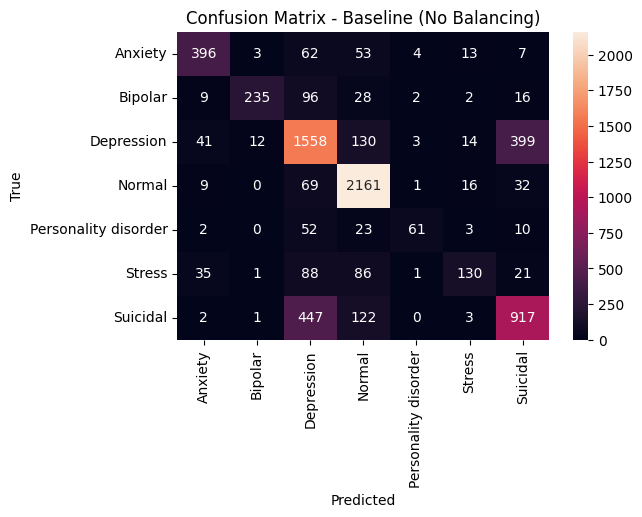


[Random Oversampling] Accuracy: 0.7321
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.79      0.75       538
             Bipolar       0.72      0.78      0.75       388
          Depression       0.74      0.58      0.65      2157
              Normal       0.88      0.91      0.90      2288
Personality disorder       0.42      0.67      0.52       151
              Stress       0.48      0.65      0.55       362
            Suicidal       0.64      0.67      0.65      1492

            accuracy                           0.73      7376
           macro avg       0.66      0.72      0.68      7376
        weighted avg       0.74      0.73      0.73      7376



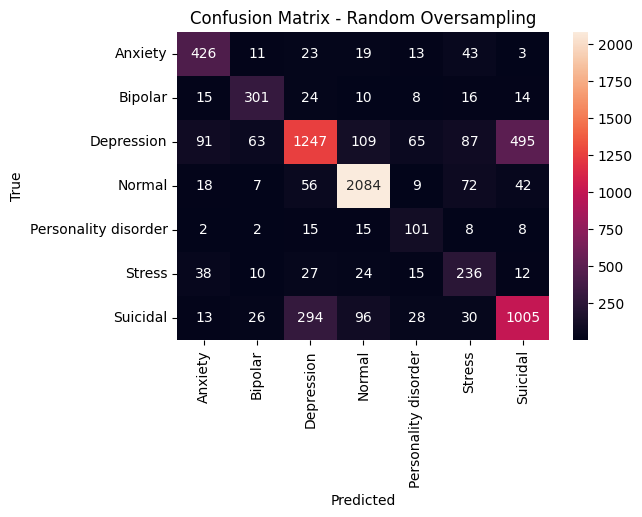


[Class Weight = 'balanced'] Accuracy: 0.7337
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.80      0.75       538
             Bipolar       0.72      0.77      0.75       388
          Depression       0.76      0.56      0.64      2157
              Normal       0.87      0.91      0.89      2288
Personality disorder       0.40      0.72      0.52       151
              Stress       0.47      0.68      0.56       362
            Suicidal       0.65      0.69      0.67      1492

            accuracy                           0.73      7376
           macro avg       0.66      0.73      0.68      7376
        weighted avg       0.75      0.73      0.73      7376



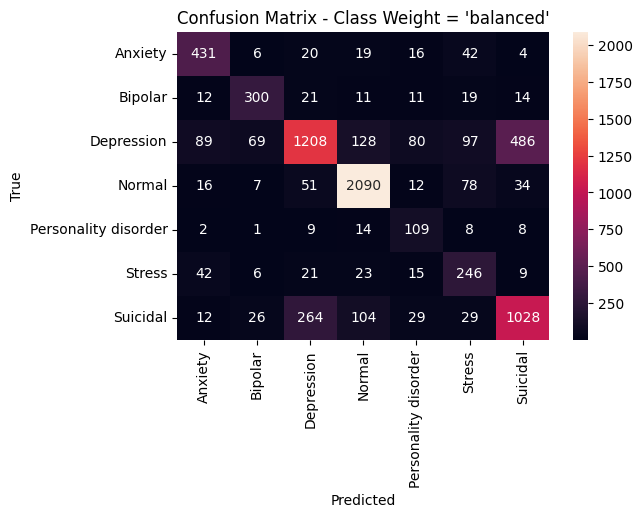

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

###############################################################################
# 1) DATA PREPARATION: LABEL ENCODING & TRAIN/TEST SPLIT
###############################################################################
# Encode the target variable
le = LabelEncoder()
df['label'] = le.fit_transform(df['Status'])

# Split the dataset into training and testing sets (using original imbalanced data)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Statement'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

###############################################################################
# 2) TF-IDF VECTORIZATION (FIT ON TRAINING DATA ONLY)
###############################################################################
# Initialize TF-IDF Vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Fit TF-IDF on the training text and transform both training and test text
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

###############################################################################
# 3) HELPER FUNCTION: EVALUATE MODEL
###############################################################################

def evaluate_model(model, X_test, y_test, approach_name):
    """
    Print Accuracy, Classification Report, and plot Confusion Matrix.
    """
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[{approach_name}] Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {approach_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

###############################################################################
# 4) BASELINE: NO CLASS BALANCING
###############################################################################

# Train a Logistic Regression model on the training set without any balancing
model_baseline = LogisticRegression(max_iter=1000)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate the baseline model on the test set
evaluate_model(model_baseline, X_test_tfidf, y_test, "Baseline (No Balancing)")

###############################################################################
# 5) RANDOM OVERSAMPLING (APPLY ON TRAINING DATA ONLY)
###############################################################################

###############################################################################
# Apply Random Oversampling only on the training data for future use
###############################################################################
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

# Train the model on the oversampled training data
model_ros = LogisticRegression(max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)

# Evaluate the oversampled model on the original imbalanced test set
evaluate_model(model_ros, X_test_tfidf, y_test, "Random Oversampling")

###############################################################################
# 6) CLASS WEIGHT BALANCED
###############################################################################
# Train a Logistic Regression model using class_weight='balanced' on the training data
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced')
model_cw.fit(X_train_tfidf, y_train)

# Evaluate the class weight balanced model on the test set
evaluate_model(model_cw, X_test_tfidf, y_test, "Class Weight = 'balanced'")

# **Step 3: Trying Random Forests**

=== RandomForest with Random Oversampling ===
Accuracy: 0.7244
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.73      0.76       538
             Bipolar       0.90      0.62      0.74       388
          Depression       0.62      0.70      0.66      2157
              Normal       0.83      0.94      0.88      2288
Personality disorder       0.99      0.44      0.61       151
              Stress       0.85      0.29      0.43       362
            Suicidal       0.63      0.58      0.60      1492

            accuracy                           0.72      7376
           macro avg       0.80      0.62      0.67      7376
        weighted avg       0.73      0.72      0.72      7376



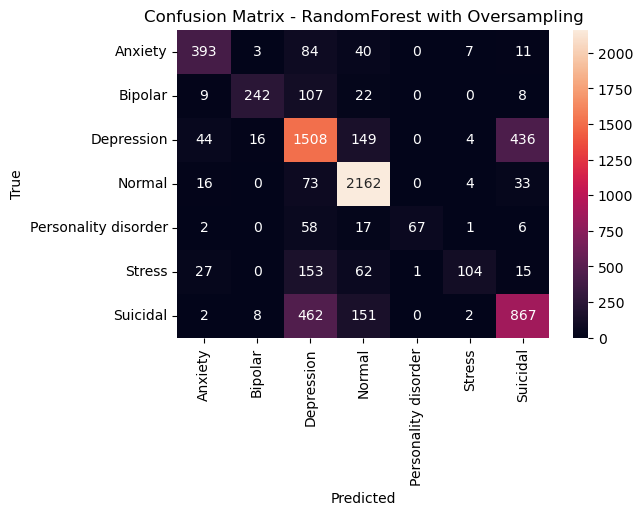


=== RandomForest with Class Weight 'balanced' ===
Accuracy: 0.7134
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.86      0.66      0.74       538
             Bipolar       0.95      0.53      0.68       388
          Depression       0.59      0.76      0.66      2157
              Normal       0.82      0.95      0.88      2288
Personality disorder       0.98      0.38      0.55       151
              Stress       0.90      0.22      0.35       362
            Suicidal       0.66      0.50      0.57      1492

            accuracy                           0.71      7376
           macro avg       0.82      0.57      0.63      7376
        weighted avg       0.74      0.71      0.70      7376



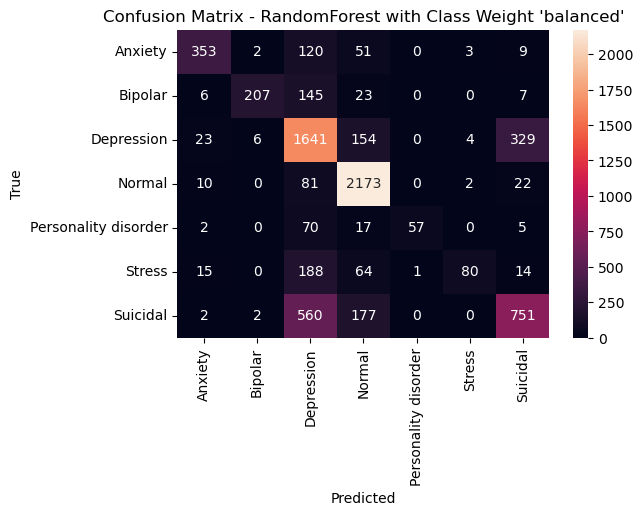

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#####################################
# Approach 1: Random Oversampling
#####################################

# Train Random Forest on the oversampled training data
rf_ros = RandomForestClassifier(random_state=42)
rf_ros.fit(X_train_ros, y_train_ros)

# Evaluate the model on the original (imbalanced) test set
y_pred_ros = rf_ros.predict(X_test_tfidf)
print("=== RandomForest with Random Oversampling ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_ros)))
print("Classification Report:")
print(classification_report(y_test, y_pred_ros, target_names=le.classes_))

# Plot confusion matrix for the oversampling approach
cm_ros = confusion_matrix(y_test, y_pred_ros)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ros, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Oversampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#####################################
# Approach 2: Class Weight Balanced Random Forest
#####################################

# Train Random Forest with class_weight='balanced'
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_cw.fit(X_train_tfidf, y_train)

# Evaluate the model on the test set
y_pred_cw = rf_cw.predict(X_test_tfidf)
print("\n=== RandomForest with Class Weight 'balanced' ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_cw)))
print("Classification Report:")
print(classification_report(y_test, y_pred_cw, target_names=le.classes_))

# Plot confusion matrix for the class weight approach
cm_cw = confusion_matrix(y_test, y_pred_cw)
plt.figure(figsize=(6,4))
sns.heatmap(cm_cw, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Class Weight 'balanced'")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from xgboost import XGBClassifier
###############################################################################
# 6) XGBOOST WITH MULTIPLE HYPERPARAMETER SETTINGS
###############################################################################
# We will train several XGBoost models with different hyperparameters
# and compare their performance on the same test set.
###############################################################################

# 6.1) Define multiple sets of hyperparameters
xgb_hyperparams = [
    {
        'n_estimators': 50,
        'max_depth': 30,
        'learning_rate': 0.1,
        'subsample': 1.0,
        'colsample_bytree': 1.0
    }
]

# 6.2) Train & Evaluate XGBoost for each hyperparameter configuration
for i, params in enumerate(xgb_hyperparams, start=1):
    print(f"\n=== XGBoost Model {i} with parameters: {params} ===")
    xgb_model = XGBClassifier(
        random_state=42,
        use_label_encoder=False,  # Suppresses a warning in newer XGBoost versions
        eval_metric='mlogloss',
        **params
    )
    xgb_model.fit(X_train_tfidf, y_train)

    approach_name = f"XGBoost Model {i}"
    evaluate_model(xgb_model, X_test_tfidf, y_test, approach_name)


=== XGBoost Model 1 with parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} ===


c:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Neural Network Model 1 with parameters: {'hidden_units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 32} ===
Epoch 1/5
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5575 - loss: 1.2671 - val_accuracy: 0.7393 - val_loss: 0.7095
Epoch 2/5
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7907 - loss: 0.5848 - val_accuracy: 0.7508 - val_loss: 0.6669
Epoch 3/5
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8351 - loss: 0.4670 - val_accuracy: 0.7410 - val_loss: 0.6937
Epoch 4/5
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8654 - loss: 0.3819 - val_accuracy: 0.7366 - val_loss: 0.7185
Epoch 5/5
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8853 - loss: 0.3271 - val_accuracy: 0.7315 - val_loss: 0.7611

Neural Network Model 1 - Test Loss: 0.7244, Test Accuracy: 0.7417
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77   

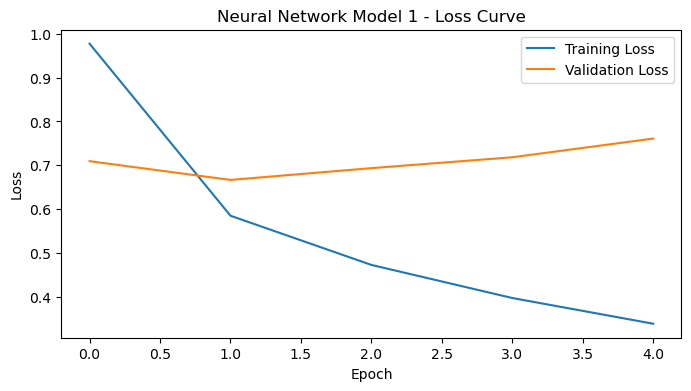

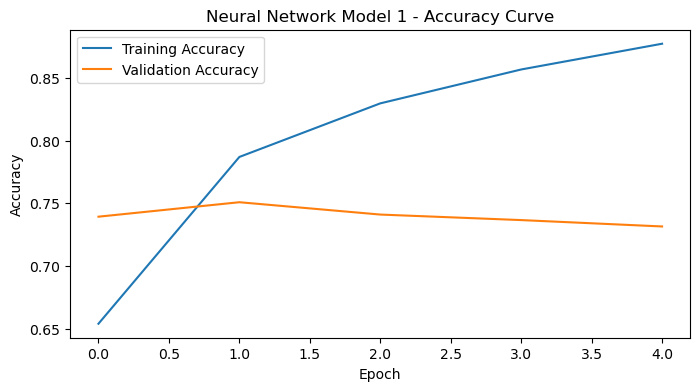


=== Neural Network Model 2 with parameters: {'hidden_units': 256, 'dropout': 0.3, 'learning_rate': 0.0005, 'epochs': 10, 'batch_size': 64} ===
Epoch 1/10


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4666 - loss: 1.5147 - val_accuracy: 0.6888 - val_loss: 0.8514
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7311 - loss: 0.7544 - val_accuracy: 0.7322 - val_loss: 0.7080
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7903 - loss: 0.5838 - val_accuracy: 0.7444 - val_loss: 0.6775
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8198 - loss: 0.5078 - val_accuracy: 0.7471 - val_loss: 0.6716
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8433 - loss: 0.4472 - val_accuracy: 0.7441 - val_loss: 0.6796
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8590 - loss: 0.4067 - val_accuracy: 0.7407 - val_loss: 0.6994
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8748 - loss: 0.3702 - val_accuracy: 0.7339 - val_loss: 0.7207
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8873 - loss: 0.3296 - val_accuracy: 0.7342 -

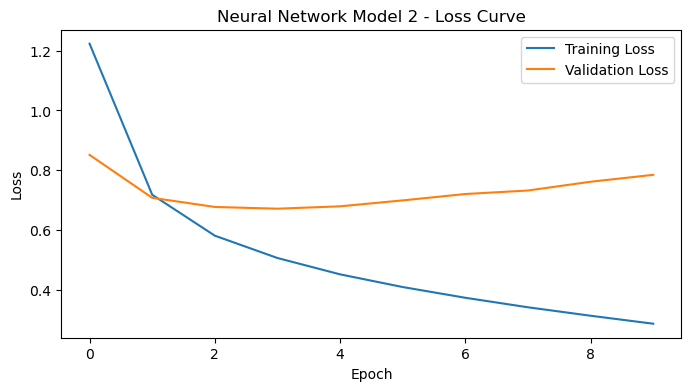

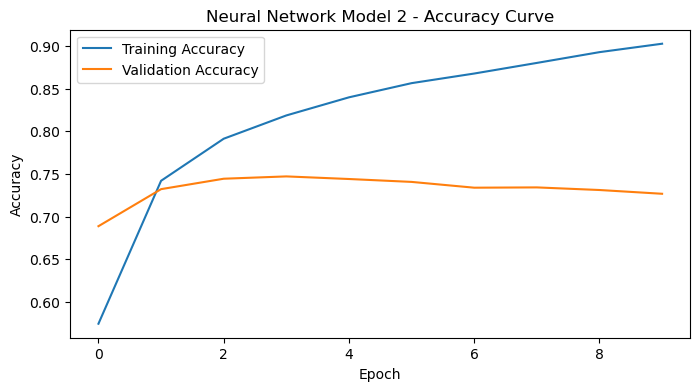


=== Neural Network Model 3 with parameters: {'hidden_units': 64, 'dropout': 0.5, 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 16} ===
Epoch 1/5


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1660/1660 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5485 - loss: 1.2917 - val_accuracy: 0.7200 - val_loss: 0.7497
Epoch 2/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7495 - loss: 0.7036 - val_accuracy: 0.7464 - val_loss: 0.6799
Epoch 3/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7906 - loss: 0.5885 - val_accuracy: 0.7522 - val_loss: 0.6665
Epoch 4/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8240 - loss: 0.4942 - val_accuracy: 0.7454 - val_loss: 0.6753
Epoch 5/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8427 - loss: 0.4525 - val_accuracy: 0.7403 - val_loss: 0.6939

Neural Network Model 3 - Test Loss: 0.6680, Test Accuracy: 0.7523
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       538
           1       0.88      0.71      0.79       388
           2       0.66      0.73      0.69      2157
           3    

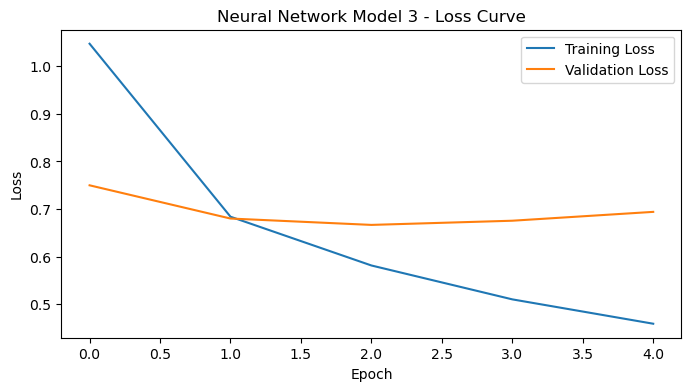

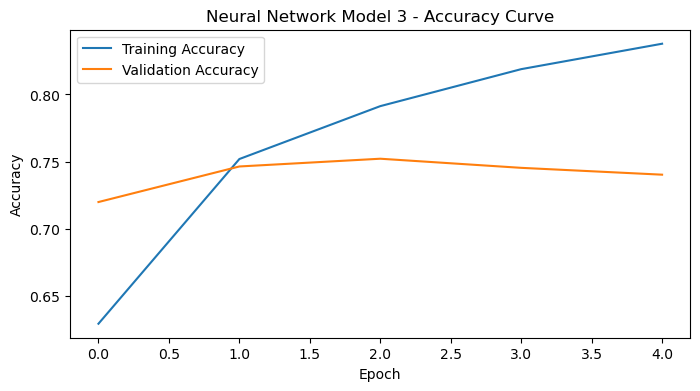


=== Deep Neural Network Model with multiple hidden layers ===
Epoch 1/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4415 - loss: 1.4361 - val_accuracy: 0.6549 - val_loss: 0.8712
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7146 - loss: 0.7470 - val_accuracy: 0.7339 - val_loss: 0.7502
Epoch 3/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8199 - loss: 0.5024 - val_accuracy: 0.7339 - val_loss: 0.7870
Epoch 4/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8845 - loss: 0.3362 - val_accuracy: 0.7275 - val_loss: 0.8897
Epoch 5/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9327 - loss: 0.2041 - val_accuracy: 0.7136 - val_loss: 1.0753
Epoch 6/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9625 - loss: 0.1197 - val_accuracy: 0.7169 - val_loss: 1.1934
Epoch 7/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9740 - loss: 0.0816 - val_accuracy: 0.7156 - val_loss: 1.2862
Epoch 8/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9815 - loss: 0.0660 - val_accuracy: 0.723

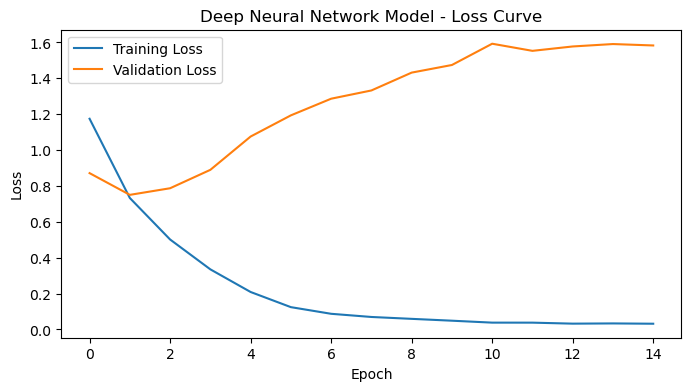

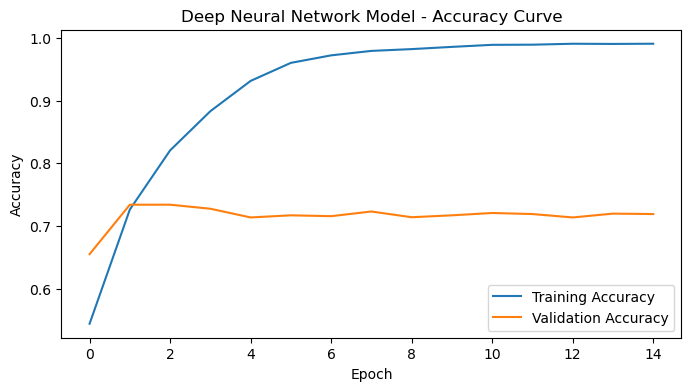

In [ ]:
import tensorflow
# Keras / TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Additional imports for evaluation and visualization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

###############################################################################
# Detailed Evaluation Function for Neural Networks
###############################################################################
def detailed_evaluation(model, history, X_test, y_test, approach_name):
    """
    Performs a detailed evaluation of the given neural network model.
    Prints test loss and accuracy, a classification report, and a confusion matrix.
    Also plots the training/validation loss and accuracy curves.

    :param model: Trained Keras model.
    :param history: History object returned from model.fit().
    :param X_test: Test set features.
    :param y_test: True labels for the test set.
    :param approach_name: A name for the model approach for display purposes.
    """
    # Evaluate on test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{approach_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Get predictions and convert probabilities to class labels
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)

    # Print a detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Compute and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot training & validation loss values
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{approach_name} - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training & validation accuracy values
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{approach_name} - Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

###############################################################################
# Function to Build a Shallow Neural Network (Single Hidden Layer)
###############################################################################
def build_model(input_dim, num_classes, hidden_units=128, dropout=0.2, learning_rate=0.001):
    """
    Builds and compiles a simple feed-forward neural network using Keras.
    :param input_dim: Size of the input layer (# of features)
    :param num_classes: Number of output classes
    :param hidden_units: Number of units in the hidden layer
    :param dropout: Dropout rate
    :param learning_rate: Learning rate for the optimizer
    """
    model = Sequential()
    # Hidden Layer
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

###############################################################################
# Function to Build a Deep Neural Network (Multiple Hidden Layers)
###############################################################################
def build_deep_model(input_dim, num_classes, hidden_layers=[256, 256, 256], dropout=0.3, learning_rate=0.001):
    """
    Builds and compiles a deep feed-forward neural network with multiple hidden layers.
    :param input_dim: Size of the input layer (# of features)
    :param num_classes: Number of output classes
    :param hidden_layers: List of integers, each representing the number of neurons in a hidden layer
    :param dropout: Dropout rate for each hidden layer
    :param learning_rate: Learning rate for the optimizer
    """
    model = Sequential()
    # First hidden layer (specify input shape)
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    # Additional hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

###############################################################################
# 6) BUILD, TRAIN, AND EVALUATE NEURAL NETWORKS WITH MULTIPLE HYPERPARAMETER SETTINGS
###############################################################################

# Example hyperparameter sets for shallow models
nn_hyperparams = [
    {
      'hidden_units': 128,
      'dropout': 0.2,
      'learning_rate': 0.001,
      'epochs': 5,
      'batch_size': 32
    },
    {
      'hidden_units': 256,
      'dropout': 0.3,
      'learning_rate': 0.0005,
      'epochs': 10,
      'batch_size': 64
    },
    {
      'hidden_units': 64,
      'dropout': 0.5,
      'learning_rate': 0.001,
      'epochs': 5,
      'batch_size': 16
    },
]

num_features = X_train_tfidf.shape[1]
num_classes = len(le.classes_)

# Train and evaluate shallow models with detailed evaluation
for i, params in enumerate(nn_hyperparams, start=1):
    approach_name = f"Neural Network Model {i}"
    print(f"\n=== {approach_name} with parameters: {params} ===")

    # Build model
    nn_model = build_model(
        input_dim=num_features,
        num_classes=num_classes,
        hidden_units=params['hidden_units'],
        dropout=params['dropout'],
        learning_rate=params['learning_rate']
    )

    # Train model
    history = nn_model.fit(
        X_train_tfidf,
        y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.1,  # 10% of training as validation
        verbose=1
    )

    # Detailed evaluation on test set
    detailed_evaluation(nn_model, history, X_test_tfidf, y_test, approach_name)

###############################################################################
# Build, Train, and Evaluate a Deep Neural Network with Multiple Hidden Layers
###############################################################################
print("\n=== Deep Neural Network Model with multiple hidden layers ===")
deep_model = build_deep_model(
    input_dim=num_features,
    num_classes=num_classes,
    hidden_layers=[512, 512, 512, 256],  # several hidden layers with a high number of neurons
    dropout=0.4,
    learning_rate=0.0005
)
deep_history = deep_model.fit(
    X_train_tfidf,
    y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)
detailed_evaluation(deep_model, deep_history, X_test_tfidf, y_test, "Deep Neural Network Model")





